In [1]:
# Imports & settings
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

DATA_PATH = "../data/cleaned/all_parks_recreation_visits.csv"


In [2]:
#Load data & quick peek
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (88869, 8)


,Park,Unit Code,Park Type,Region,State,Year,Month,Recreation Visits
0,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,1,0.0
1,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,2,0.0
2,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,3,0.0
3,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,4,965.0
4,Adams NHP,ADAM,National Historical Park,Northeast,MA,1979,5,2428.0


In [3]:
# enforce numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Month"] = pd.to_numeric(df["Month"], errors="coerce")
df["Recreation Visits"] = pd.to_numeric(df["Recreation Visits"], errors="coerce")

In [4]:
# drop invalid rows
df = df.dropna(subset=["Year","Month","Recreation Visits"])
df["Year"] = df["Year"].astype(int)
df["Month"] = df["Month"].astype(int)
df["Recreation Visits"] = df["Recreation Visits"].astype(int)


In [5]:
# date column for time analysis
df["Date"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))


In [6]:
# de-dup just in case
before = len(df)
df = df.drop_duplicates()
print(f"Rows after clean/dedup: {len(df)} (dropped {before - len(df)})")

df.describe(include="all")

Rows after clean/dedup: 88413 (dropped 456)


,Park,Unit Code,Park Type,Region,State,Year,Month,Recreation Visits,Date
count,88413,88413,88413,88413,87705,88413.000000,88413.000000,8.841300e+04,88413
unique,178,178,17,7,43,NaN,NaN,NaN,NaN
top,Adams NHP,ADAM,National Monument,Intermountain,FL,NaN,NaN,NaN,NaN
freq,552,552,20046,24168,5400,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2002.273252,6.500503,7.801331e+04,2002-09-24 09:39:30.886634368
min,NaN,NaN,NaN,NaN,NaN,1979.000000,1.000000,0.000000e+00,1979-01-01 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,1991.000000,4.000000,3.135000e+03,1991-06-01 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,2003.000000,7.000000,1.218200e+04,2003-02-01 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,2014.000000,10.000000,5.694400e+04,2014-04-01 00:00:00
max,NaN,NaN,NaN,NaN,NaN,2024.000000,12.000000,3.912215e+06,2024-12-01 00:00:00


In [7]:
# Sanity checks (missing, ranges)
print("Year range:", df["Year"].min(), "→", df["Year"].max())
print("Months unique:", sorted(df["Month"].unique()))
print("Parks:", df["Park"].nunique(), "| States:", df["State"].nunique(), "| Regions:", df["Region"].nunique())

# Basic missing check (should be none after dropna)
df.isna().sum()

Year range: 1979 → 2024
Months unique: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
Parks: 178 | States: 43 | Regions: 7


Park                   0
Unit Code              0
Park Type              0
Region                 0
State                708
Year                   0
Month                  0
Recreation Visits      0
Date                   0
dtype: int64

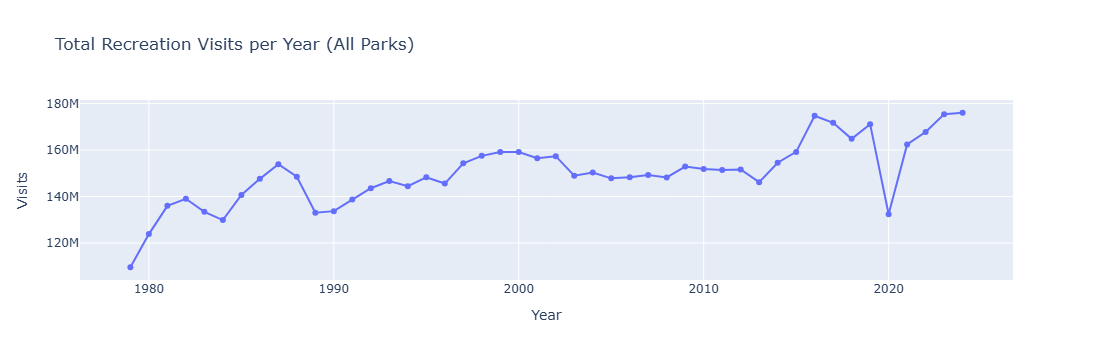

In [11]:
#Totals by year (interactive)
yearly = df.groupby("Year", as_index=False)["Recreation Visits"].sum()

fig = px.line(
    yearly, x="Year", y="Recreation Visits",
    title="Total Recreation Visits per Year (All Parks)",
    markers=True
)
fig.update_layout(yaxis_title="Visits", xaxis_title="Year")
fig.show()


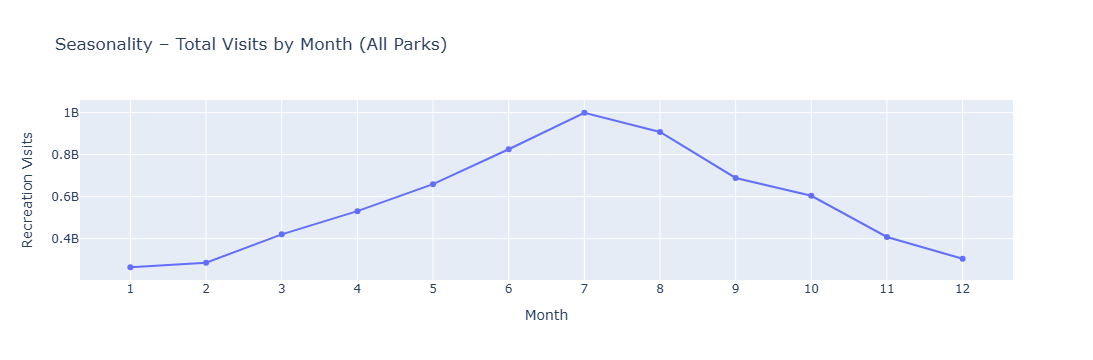

In [12]:
# Seasonality (all parks combined)
monthly = df.groupby("Month", as_index=False)["Recreation Visits"].sum().sort_values("Month")

fig = px.line(
    monthly, x="Month", y="Recreation Visits",
    title="Seasonality – Total Visits by Month (All Parks)",
    markers=True
)
fig.update_xaxes(dtick=1)
fig.show()


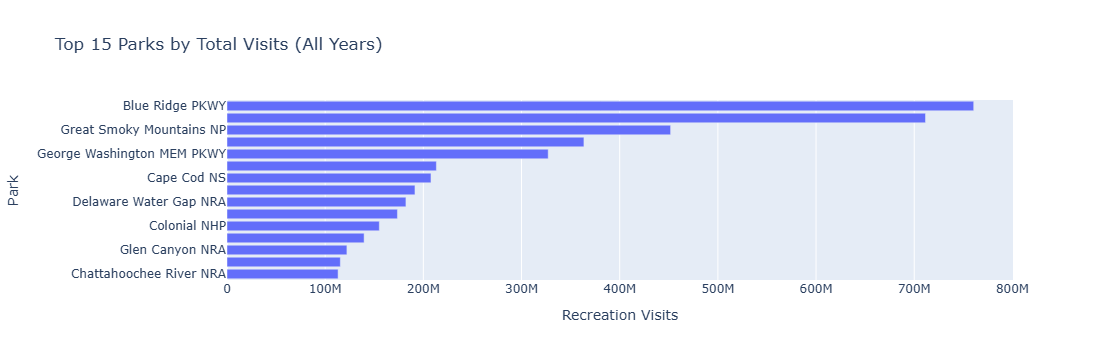

In [13]:
# Top 15 parks (all time)
top_parks = (
    df.groupby("Park", as_index=False)["Recreation Visits"].sum()
      .sort_values("Recreation Visits", ascending=False)
      .head(15)
)

fig = px.bar(
    top_parks, x="Recreation Visits", y="Park",
    orientation="h", title="Top 15 Parks by Total Visits (All Years)"
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


In [14]:
# YoY growth per park, latest month per park ---

# Monthly panel per park
park_month = (
    df.groupby(["Park","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
park_month["Date"] = pd.to_datetime(dict(year=park_month["Year"], month=park_month["Month"], day=1))


In [15]:
# Previous-year same-month baseline
park_month = park_month.sort_values(["Park","Date"])
park_month["Prev_Year_Visits"] = park_month.groupby("Park")["Recreation Visits"].shift(12)

In [16]:
# YoY growth
park_month["YoY_Growth"] = (
    (park_month["Recreation Visits"] - park_month["Prev_Year_Visits"]) / park_month["Prev_Year_Visits"]
)

In [17]:
# Get the latest row per park (no groupby-apply, so no warning)
latest_idx = park_month.groupby("Park")["Date"].idxmax()
latest = park_month.loc[latest_idx].copy()


In [18]:
# Keep only parks with a valid YoY baseline
latest = latest.replace([np.inf, -np.inf], np.nan).dropna(subset=["YoY_Growth"])

# Top gainers / decliners
top_gainers   = latest.sort_values("YoY_Growth", ascending=False).head(10)
top_decliners = latest.sort_values("YoY_Growth", ascending=True).head(10)

print("Top YoY Gainers:")
display(top_gainers[["Park","Year","Month","Recreation Visits","Prev_Year_Visits","YoY_Growth"]])

print("\nTop YoY Decliners:")
display(top_decliners[["Park","Year","Month","Recreation Visits","Prev_Year_Visits","YoY_Growth"]])

Top YoY Gainers:


,Park,Year,Month,Recreation Visits,Prev_Year_Visits,YoY_Growth
5387,Arlington House The R.E. Lee MEM,2024,12,18689,6064.0,2.081959
76496,Great Basin NP,2024,12,3693,1260.0,1.930952
14723,Boston Harbor Islands NRA,2024,12,2500,950.0,1.631579
24763,Casa Grande Ruins NM,2024,12,9499,3963.0,1.396922
86204,Hopewell Furnace NHS,2024,12,2031,870.0,1.334483
13679,Bluestone NSR,2024,12,639,300.0,1.130000
27667,Chaco Culture NHP,2024,12,1984,937.0,1.117396
27115,Cesar E. Chavez NM,2024,12,1658,846.0,0.959811
7595,Bandelier NM,2024,12,17514,9140.0,0.916193
66854,Gauley River NRA,2024,12,5484,2929.0,0.872311



Top YoY Decliners:


,Park,Year,Month,Recreation Visits,Prev_Year_Visits,YoY_Growth
44502,Edgar Allan Poe NHS,2024,12,0,1177.0,-1.000000
40038,De Soto NMEM,2024,12,0,18207.0,-1.000000
67406,General Grant NMEM,2024,12,1156,8184.0,-0.858749
23563,Carl Sandburg Home NHS,2024,12,1598,9455.0,-0.830989
8255,Bent's Old Fort NHS,2024,12,156,638.0,-0.755486
1667,Andrew Johnson NHS,2024,12,2190,8597.0,-0.745260
68510,George Washington Birthplace NM,2024,12,765,2220.0,-0.655405
81824,Hampton NHS,2024,12,748,1756.0,-0.574032
36378,Crater Lake NP,2024,12,5005,11432.0,-0.562194
87860,Hovenweep NM,2024,12,318,700.0,-0.545714


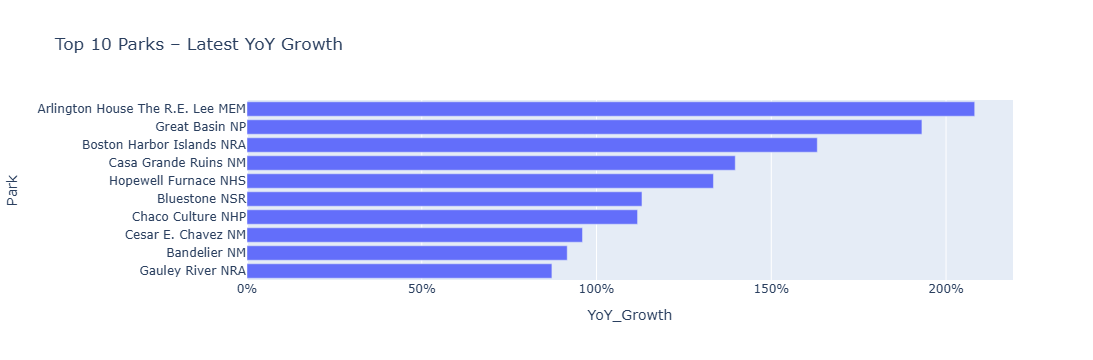

In [19]:
fig = px.bar(
    top_gainers.sort_values("YoY_Growth"),
    x="YoY_Growth", y="Park", orientation="h",
    title="Top 10 Parks – Latest YoY Growth"
)
fig.update_layout(xaxis_tickformat=".0%")
fig.show()


In [20]:
# State & Region summaries (for map and dashboard)
# State-month
state_month = (
    df.groupby(["State","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
state_month["Date"] = pd.to_datetime(dict(year=state_month["Year"], month=state_month["Month"], day=1))

In [21]:
# Region-month
region_month = (
    df.groupby(["Region","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
region_month["Date"] = pd.to_datetime(dict(year=region_month["Year"], month=region_month["Month"], day=1))

In [22]:
# (map & filters)
state_month.to_csv("../data/cleaned/state_month_visits.csv", index=False)
region_month.to_csv("../data/cleaned/region_month_visits.csv", index=False)

state_month.head(), region_month.head()

(  State  Year  Month  Recreation Visits       Date
 0    AK  1979      1                502 1979-01-01
 1    AK  1979      2                193 1979-02-01
 2    AK  1979      3                720 1979-03-01
 3    AK  1979      4               1127 1979-04-01
 4    AK  1979      5              17425 1979-05-01,
    Region  Year  Month  Recreation Visits       Date
 0  Alaska  1979      1                502 1979-01-01
 1  Alaska  1979      2                193 1979-02-01
 2  Alaska  1979      3                720 1979-03-01
 3  Alaska  1979      4               1127 1979-04-01
 4  Alaska  1979      5              17425 1979-05-01)

In [23]:
# Seasonality index (per park)
park_month_total = (
    df.groupby(["Park","Month"], as_index=False)["Recreation Visits"].sum()
)

park_total_year = (
    df.groupby("Park", as_index=False)["Recreation Visits"].sum()
      .rename(columns={"Recreation Visits":"Total_Visits"})
)

In [24]:
# average per month = total / number of unique months present for the park
months_per_park = df.groupby("Park")["Month"].nunique().reset_index().rename(columns={"Month":"Months_Count"})
park_total_year = park_total_year.merge(months_per_park, on="Park", how="left")

park_month_avg = park_month_total.merge(park_total_year, on="Park", how="left")
park_month_avg["Avg_Per_Month"] = park_month_avg["Total_Visits"] / park_month_avg["Months_Count"]

In [25]:
#  index: month_visits / avg_per_month
park_month_avg["Seasonality_Index"] = park_month_avg["Recreation Visits"] / park_month_avg["Avg_Per_Month"]
park_month_avg.to_csv("../data/cleaned/park_seasonality_index.csv", index=False)
park_month_avg.head()

,Park,Month,Recreation Visits,Total_Visits,Months_Count,Avg_Per_Month,Seasonality_Index
0,Adams NHP,1,37206,4931861,12,410988.416667,0.090528
1,Adams NHP,2,63858,4931861,12,410988.416667,0.155377
2,Adams NHP,3,66681,4931861,12,410988.416667,0.162245
3,Adams NHP,4,245440,4931861,12,410988.416667,0.597194
4,Adams NHP,5,540491,4931861,12,410988.416667,1.315100


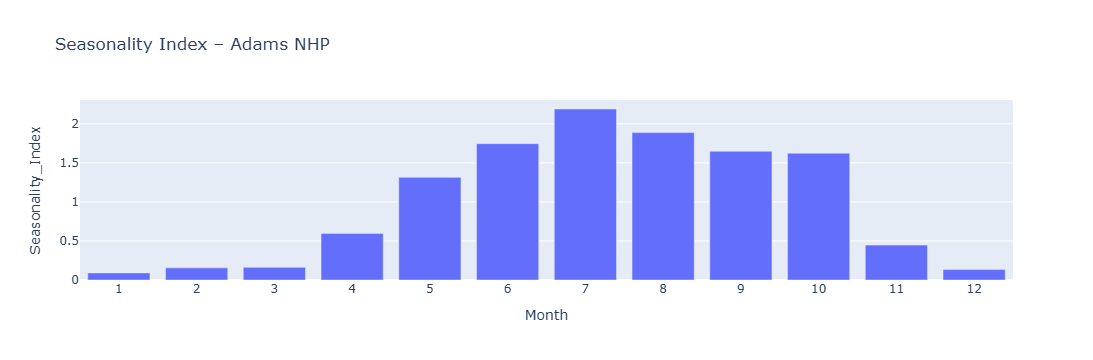

In [26]:
# Heatmap for one park example:
one = park_month_avg[park_month_avg["Park"] == park_month_avg["Park"].iloc[0]]
fig = px.bar(one, x="Month", y="Seasonality_Index", title=f"Seasonality Index – {one['Park'].iloc[0]}")
fig.update_xaxes(dtick=1)
fig.show()


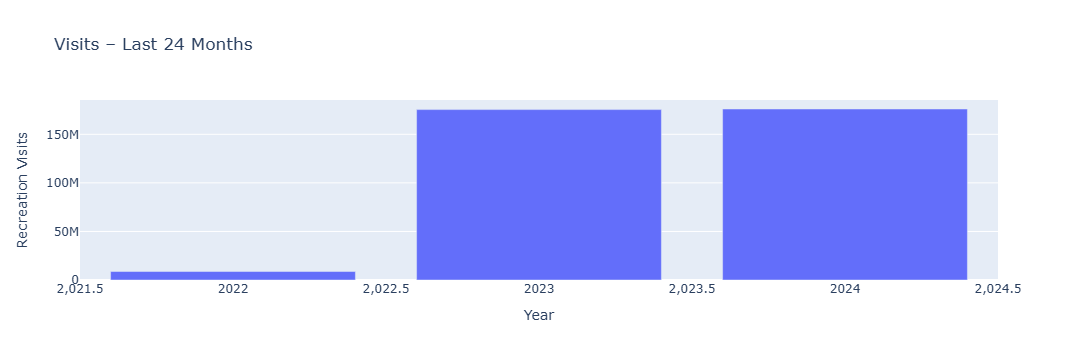

,State,Date,Recreation Visits
0,AK,2022-12-01,3990
825,TN,2022-12-01,735091
50,AR,2022-12-01,239688
800,SD,2022-12-01,6266
775,SC,2022-12-01,47892


In [27]:
# Recent period focus (last 24 months)
cutoff = df["Date"].max() - pd.DateOffset(months=24)
recent = df[df["Date"] >= cutoff].copy()

recent_yearly = recent.groupby("Year", as_index=False)["Recreation Visits"].sum()
px.bar(recent_yearly, x="Year", y="Recreation Visits", title="Visits – Last 24 Months").show()

recent_monthly_state = (
    recent.groupby(["State","Date"], as_index=False)["Recreation Visits"].sum()
)
recent_monthly_state.sort_values("Date").head()


In [28]:
# Save EDA artifacts for the dashboard
df.to_csv("../data/cleaned/_eda_base_all_rows.csv", index=False)
yearly.to_csv("../data/cleaned/_eda_yearly_totals.csv", index=False)
monthly.to_csv("../data/cleaned/_eda_monthly_totals.csv", index=False)
top_parks.to_csv("../data/cleaned/_eda_top_parks_total.csv", index=False)
park_month.to_csv("../data/cleaned/_eda_park_month_panel.csv", index=False)
latest.to_csv("../data/cleaned/_eda_latest_yoy_per_park.csv", index=False)


In [29]:
# Quick data-quality flags
# Impossible month values?
print("Bad months:", df.loc[~df["Month"].between(1,12)].shape[0])

# Extremely large spikes (top 0.1%)
cap = df["Recreation Visits"].quantile(0.999)
spikes = df[df["Recreation Visits"] >= cap].sort_values("Recreation Visits", ascending=False)
print(f"Extreme spikes (>= {int(cap)}):", len(spikes))
spikes.head(10)


Bad months: 0
Extreme spikes (>= 2205084): 89


,Park,Unit Code,Park Type,Region,State,Year,Month,Recreation Visits,Date
66381,Gateway NRA,GATE,National Recreation Area,Northeast,NY,1979,7,3912215,1979-07-01
66405,Gateway NRA,GATE,National Recreation Area,Northeast,NY,1981,7,3493360,1981-07-01
66417,Gateway NRA,GATE,National Recreation Area,Northeast,NY,1982,7,3394057,1982-07-01
12849,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1987,10,3181024,1987-10-01
66429,Gateway NRA,GATE,National Recreation Area,Northeast,NY,1983,7,3150909,1983-07-01
66393,Gateway NRA,GATE,National Recreation Area,Northeast,NY,1980,7,3071490,1980-07-01
13026,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,2002,7,2899584,2002-07-01
66394,Gateway NRA,GATE,National Recreation Area,Northeast,NY,1980,8,2883821,1980-08-01
12861,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1988,10,2854160,1988-10-01
12824,Blue Ridge PKWY,BLRI,National Parkway,Southeast,NC,1985,9,2827523,1985-09-01


In [30]:
# Hotspot vs Off-Season Labeling by State
# Hotspot vs Off-Season labeling ---

selected_year  = 2024
selected_month = 7

# Filter for that month
month_df = df[(df["Year"] == selected_year) & (df["Month"] == selected_month)]

# Aggregate at state level
state_avg = (
    month_df.groupby("State", as_index=False)["Recreation Visits"].mean()
)

# Determine thresholds
hot_threshold = state_avg["Recreation Visits"].quantile(0.75)
cold_threshold = state_avg["Recreation Visits"].quantile(0.25)

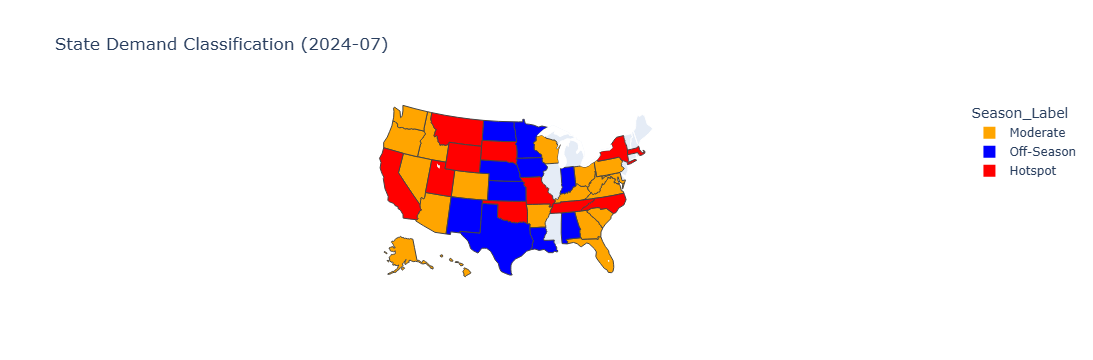

In [31]:
# Assign category
state_avg["Season_Label"] = state_avg["Recreation Visits"].apply(
    lambda x: "Hotspot" if x >= hot_threshold else ("Off-Season" if x <= cold_threshold else "Moderate")
)

fig = px.choropleth(
    state_avg,
    locations="State", locationmode="USA-states",
    color="Season_Label",
    title=f"State Demand Classification ({selected_year}-{selected_month:02d})",
    scope="usa",
    color_discrete_map={"Hotspot":"red","Moderate":"orange","Off-Season":"blue"}
)
fig.show()

In [32]:
#  Create monthly series per park
park_ts = (
    df.groupby(["Park","Year","Month"], as_index=False)["Recreation Visits"].sum()
)
park_ts["Date"] = pd.to_datetime(dict(year=park_ts["Year"], month=park_ts["Month"], day=1))

In [33]:
# Sort and compute rolling sum
park_ts = park_ts.sort_values(["Park","Date"])
park_ts["Rolling_12M"] = park_ts.groupby("Park")["Recreation Visits"].transform(lambda x: x.rolling(12, min_periods=6).sum())

# Compute month-to-month growth
park_ts["Rolling_Growth"] = park_ts.groupby("Park")["Rolling_12M"].pct_change(fill_method=None)


In [34]:
# Get latest available growth
latest_rows = park_ts.groupby("Park")["Date"].idxmax()
latest_growth = park_ts.loc[latest_rows].dropna(subset=["Rolling_Growth"])

# Top trending
top_trending = latest_growth.sort_values("Rolling_Growth", ascending=False).head(10)

print("Top 10 Trending Parks (12-Month Rolling Growth):")
display(top_trending[["Park","Rolling_12M","Rolling_Growth"]])


Top 10 Trending Parks (12-Month Rolling Growth):


,Park,Rolling_12M,Rolling_Growth
563,Amache NHS,4771.0,0.088772
14723,Boston Harbor Islands NRA,28157.0,0.058255
24763,Casa Grande Ruins NM,104429.0,0.055980
9563,Big Cypress NPRES,2216708.0,0.053804
13679,Bluestone NSR,7327.0,0.048512
19183,Canyon de Chelly NM,387433.0,0.047855
28890,Charles Young Buffalo Soldiers NM,4716.0,0.044287
18631,Cane River Creole NHP,12592.0,0.043421
7595,Bandelier NM,213595.0,0.040805
27115,Cesar E. Chavez NM,26641.0,0.031438


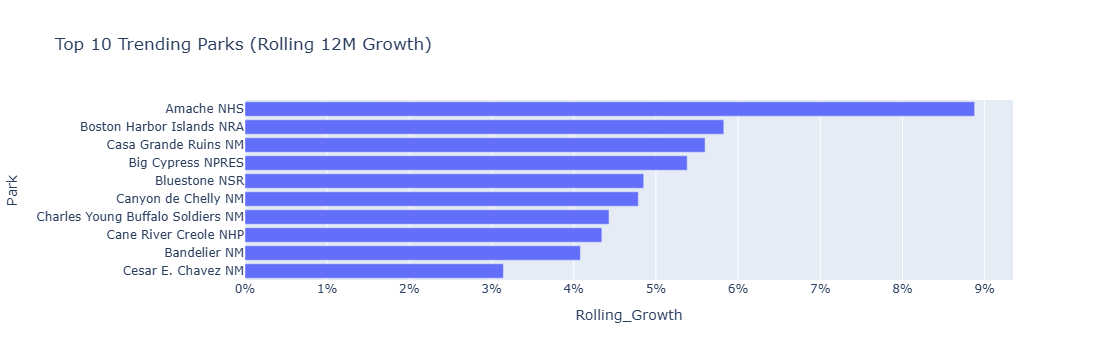

In [35]:
# Chart
fig = px.bar(
    top_trending.sort_values("Rolling_Growth"),
    x="Rolling_Growth", y="Park", orientation="h",
    title="Top 10 Trending Parks (Rolling 12M Growth)"
)
fig.update_layout(xaxis_tickformat=".0%")
fig.show()